# **Analisis Sentimen Etika AI: Crawling dan Klasifikasi Data Twitter**

Notebook ini melakukan analisis sentimen terhadap tweet-tweet yang membahas etika AI (Artificial Intelligence) dengan menggunakan berbagai metode machine learning seperti SVM, Random Forest, dan Naive Bayes untuk mengklasifikasikan sentimen positif dan negatif.

# Install All Required Libraries (Linux)
Jalankan sel ini sebelum menjalankan notebook untuk memastikan semua library yang dibutuhkan sudah terpasang di Linux. Gunakan `sudo` jika diperlukan.

In [2]:
import os
import subprocess

# Install required Python packages (Linux)
!sudo pip3 install pandas numpy nltk sastrawi swifter openpyxl xlrd vaderSentiment scikit-learn matplotlib seaborn wordcloud pytz

# Install Node.js (because tweet-harvest built using Node.js)
!sudo apt-get update
!sudo apt-get install -y ca-certificates curl gnupg
!sudo mkdir -p /etc/apt/keyrings
!curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

!NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

!sudo apt-get update
!sudo apt-get install nodejs -y

!node -v


Command not found
Command not found
'NODE_MAJOR' is not recognized as an internal or external command,
operable program or batch file.
Command not found
Command not found


v22.15.0


# Install All Required Libraries (Windows 11)
Jalankan sel ini sebelum menjalankan notebook untuk memastikan semua library yang dibutuhkan sudah terpasang.

In [3]:
import os
import subprocess

# Import required Python package
!pip install pandas numpy nltk sastrawi swifter openpyxl xlrd vaderSentiment scikit-learn matplotlib seaborn wordcloud pytz

# For Windows 11, we'll use the npm package manager that comes with Node.js
# You should install Node.js manually from https://nodejs.org/ if not already installed
# The following command will check if Node.js is installed


# Check if Node.js is installed
try:
    node_version = subprocess.check_output("node -v", shell=True).decode().strip()
    print(f"Node.js is installed with version: {node_version}")
except:
    print("Node.js is not installed. Please install from https://nodejs.org/")
    print("After installation, restart this notebook or your kernel")

# Check if npm is installed
try:
    npm_version = subprocess.check_output("npm -v", shell=True).decode().strip()
    print(f"npm is installed with version: {npm_version}")
except:
    print("npm is not installed. It should come with Node.js installation.")

# We'll install tweet-harvest globally using npm when Node.js is confirmed installed
# This step will be executed only if Node.js is detected
if 'node_version' in locals():
    print("Ready to install tweet-harvest when needed in the crawling cell")

Node.js is installed with version: v22.15.0
npm is installed with version: 11.0.0
Ready to install tweet-harvest when needed in the crawling cell


In [ ]:
#@title Twitter Auth Token

#twitter_auth_token = '#ubah dengan auth token' # change this auth token'
with open('auth.key', 'r') as f: # read the auth token from a file in the same directory
    twitter_auth_token = f.read().strip()

In [ ]:
# Crawl Data

filename = 'etikaAI.csv'
search_keyword = 'etika ai since:2025-01-01 lang:id'
limit = 1000

!npx -y tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" --tab "LATEST" -l {limit} --token {twitter_auth_token}

In [4]:
import pandas as pd
import re

# Read the CSV file and handle the malformed structure
file_path = "tweets-data/etikaAI.csv"

# Read the raw file to parse it properly
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Extract and parse the malformed header
header_line = lines[0].strip()
# The header format: "conversation_id_str,""created_at"",""favorite_count"",...""username""";;;
# Remove the trailing ;;; and parse the header
header_line = header_line.replace(';;;', '')

# Extract column names using regex to find quoted strings
header_matches = re.findall(r'"([^"]*)"', header_line)
if not header_matches:
    # Fallback: split by comma and clean
    header_parts = header_line.split(',')
    headers = []
    for part in header_parts:
        clean_header = part.strip().replace('"', '').replace("'", "")
        if clean_header and clean_header not in ['', ';;;']:
            headers.append(clean_header)
else:
    headers = header_matches

# Clean up headers - remove empty strings and duplicates
headers = [h for h in headers if h.strip()]
if len(headers) == 0:
    # Use default headers if parsing fails
    headers = ['conversation_id_str', 'created_at', 'favorite_count', 'full_text', 'id_str', 
               'image_url', 'in_reply_to_screen_name', 'lang', 'location', 'quote_count', 
               'reply_count', 'retweet_count', 'tweet_url', 'user_id_str', 'username']

print(f"Parsed headers: {headers}")

# Process data lines
data_rows = []
for line in lines[1:]:
    line = line.strip()
    if line and not line.startswith(';;;'):
        # Remove the trailing ;;; and extract quoted values
        line = line.replace(';;;', '')
        # Use regex to extract quoted content
        parts = re.findall(r'"([^"]*)"', line)
        if len(parts) >= len(headers):
            data_rows.append(parts[:len(headers)])
        elif len(parts) > 0:
            # Pad with empty strings if needed
            padded_parts = parts + [''] * (len(headers) - len(parts))
            data_rows.append(padded_parts[:len(headers)])

# Create DataFrame
df = pd.DataFrame(data_rows, columns=headers)

# Clean up the data
df = df.dropna(subset=['full_text'])  # Remove rows without text
df = df[df['full_text'].str.strip() != '']  # Remove rows with empty text

print(f"Loaded {len(df)} tweets")
print("Column names:", df.columns.tolist())
print("\nDataFrame shape:", df.shape)
print("\nFirst few tweets:")
if 'full_text' in df.columns:
    print(df[['full_text']].head(3))
    if 'username' in df.columns:
        print("\nUsernames:")
        print(df[['username']].head(3))
    if 'created_at' in df.columns:
        print("\nCreated at:")
        print(df[['created_at']].head(3))

Parsed headers: ['conversation_id_str,', 'created_at', ',', 'favorite_count', ',', 'full_text', ',', 'id_str', ',', 'image_url', ',', 'in_reply_to_screen_name', ',', 'lang', ',', 'location', ',', 'quote_count', ',', 'reply_count', ',', 'retweet_count', ',', 'tweet_url', ',', 'user_id_str', ',', 'username']
Loaded 999 tweets
Column names: ['conversation_id_str,', 'created_at', ',', 'favorite_count', ',', 'full_text', ',', 'id_str', ',', 'image_url', ',', 'in_reply_to_screen_name', ',', 'lang', ',', 'location', ',', 'quote_count', ',', 'reply_count', ',', 'retweet_count', ',', 'tweet_url', ',', 'user_id_str', ',', 'username']

DataFrame shape: (999, 28)

First few tweets:
                                           full_text
0  Kenapa AI hrus ditekankan etika penggunaannya?...
1  #AInews Beberapa pihak telah menemukan cara ya...
2  #AInews Beberapa pihak telah menemukan cara ya...

Usernames:
    username
0  retardeus
1  AsistenAI
2  AsistenAI

Created at:
                       created_a

In [5]:
# Cek jumlah data yang didapatkan

num_tweets = len(df)
print(f"Jumlah tweet dalam dataframe adalah {num_tweets}.")

Jumlah tweet dalam dataframe adalah 999.


## **PREPROCESSING**

In [6]:
#import nltk digunakan untuk mengimpor modul NLTK (Natural Language Toolkit) ke dalam program Python
#nltk.download('punkt') digunakan untuk mengunduh data yang diperlukan oleh tokenisasi Punkt dari NLTK.
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Aristo
[nltk_data]     Baadi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Aristo
[nltk_data]     Baadi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
import string
import re #regex library

# import word_tokenize & FreqDist from NLTK
# adalah dua fungsi yang diimpor dari modul NLTK (Natural Language Toolkit) dalam Python
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [8]:
def remove_tweet_special(text):
    # remove tab, new line, and backslash
    text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace("\\", "")
    # remove non ASCII (emoticon, chinese word, etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

# Apply the preprocessing to the full_text column
if 'full_text' in df.columns:
    df['full_text_Tokenizing'] = df['full_text'].apply(remove_tweet_special)
    print("Successfully applied tweet special character removal")
    print("Sample processed text:")
    print(df[['full_text', 'full_text_Tokenizing']].head(3))
else:
    print("Error: 'full_text' column not found. Available columns:", df.columns.tolist())

display(df)

Successfully applied tweet special character removal
Sample processed text:
                                           full_text  \
0  Kenapa AI hrus ditekankan etika penggunaannya?...   
1  #AInews Beberapa pihak telah menemukan cara ya...   
2  #AInews Beberapa pihak telah menemukan cara ya...   

                                full_text_Tokenizing  
0  Kenapa AI hrus ditekankan etika penggunaannya?...  
1  Beberapa pihak telah menemukan cara yang lebih...  
2  Beberapa pihak telah menemukan cara yang lebih...  


,"conversation_id_str,",created_at,",",favorite_count,",",full_text,",",id_str,",",image_url,...,reply_count,",",retweet_count,",",tweet_url,",",user_id_str,",",username,full_text_Tokenizing
0,"1923900123882586560,",Sun May 18 00:35:08 +0000 2025,",",0,",",Kenapa AI hrus ditekankan etika penggunaannya?...,",",1923900123882586560,",",,...,0,",",0,",",https://x.com/retardeus/status/192390012388258...,",",273549006,",",retardeus,Kenapa AI hrus ditekankan etika penggunaannya?...
1,"1923790443034116494,",Sat May 17 17:19:18 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923790443034116494,",",,...,0,",",0,",",https://x.com/AsistenAI/status/192379044303411...,",",1627580091034406912,",",AsistenAI,Beberapa pihak telah menemukan cara yang lebih...
2,"1923645506359533575,",Sat May 17 07:43:22 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923645506359533575,",",,...,0,",",0,",",https://x.com/AsistenAI/status/192364550635953...,",",1627580091034406912,",",AsistenAI,Beberapa pihak telah menemukan cara yang lebih...
3,"1923603672044535931,",Sat May 17 04:57:08 +0000 2025,",",0,",",Komdigi minta Dewan Pers tingkatkan etika jurn...,",",1923603672044535931,",",https://pbs.twimg.com/media/GrIDRsaXcAApt4l.jpg,...,0,",",0,",",https://x.com/MPN_Indonesia/status/19236036720...,",",483100064,",",MPN_Indonesia,Komdigi minta Dewan Pers tingkatkan etika jurn...
4,"1923356170623889673,",Fri May 16 12:45:44 +0000 2025,",",0,",",@adieumeteur Oke ka Yuji paham kok maksudnya. ...,",",1923359209808138446,",",,...,1,",",0,",",https://x.com/itsjdpp/status/1923359209808138446,",",1279322729959710722,",",itsjdpp,Oke ka Yuji paham kok maksudnya. emang AI puny...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"1892454069328830627,",Thu Feb 20 05:59:45 +0000 2025,",",0,",",Tapi yaa...tau ah kok gw malah mikirin lu. Int...,",",1892454071715713140,",",,...,1,",",0,",",https://x.com/iamraraa_ai/status/1892454071715...,",",1641383545540325376,",",iamraraa_ai,Tapi yaa...tau ah kok gw malah mikirin lu. Int...
995,"1892265234703782026,",Wed Feb 19 17:29:23 +0000 2025,",",1,",",Gue udh kebayang sih ini AI agent jd exploiter...,",",1892265234703782026,",",,...,0,",",0,",",https://x.com/0xhelmtempur/status/189226523470...,",",122903185,",",0xhelmtempur,Gue udh kebayang sih ini AI agent jd exploiter...
996,"1892003767366582530,",Wed Feb 19 00:11:05 +0000 2025,",",0,",",Dr. Khaerunesa Isa dari Universiti Tun Hussein...,",",1892003937416339874,",",,...,1,",",0,",",https://x.com/fpkuinsa/status/1892003937416339874,",",1407540427637465098,",",fpkuinsa,Dr. Khaerunesa Isa dari Universiti Tun Hussein...
997,"1892003767366582530,",Wed Feb 19 00:10:24 +0000 2025,",",0,",",[FPK REPORT] Datangkan Narasumber dari Malaysi...,",",1892003767366582530,",",https://pbs.twimg.com/media/GkG_U8SWEAA0Krs.jpg,...,1,",",0,",",https://x.com/fpkuinsa/status/1892003767366582530,",",1407540427637465098,",",fpkuinsa,[FPK REPORT] Datangkan Narasumber dari Malaysi...


# **CASE FOLDING**

In [9]:
# ------ Case Folding --------
# Perbaikan: DataFrame Anda hanya memiliki satu kolom besar (belum terpisah).
# Solusi: Pisahkan kolom terlebih dahulu menggunakan pd.read_csv dengan delimiter yang benar.

import pandas as pd

# Cek apakah df hanya punya 1 kolom (belum diparse)
if len(df.columns) == 1:
	# Ambil nama kolom tunggal
	col_name = df.columns[0]
	# Split kolom menjadi beberapa kolom berdasarkan koma
	df_split = df[col_name].str.split('","', expand=True)
	# Bersihkan header
	header = df_split.iloc[0].str.replace('"', '').str.replace("'", "")
	df_split.columns = header
	df_split = df_split[1:]  # drop header row
	df_split.reset_index(drop=True, inplace=True)
	df = df_split

# Check the columns after the split
print("Kolom setelah split manual:", df.columns)

# 1. Properly handle CSV parsing:
# Try reading the CSV with different delimiters to handle potential issues in the CSV file
# If the file is truly comma-separated, this should work. If not, you may need to adjust the delimiter.

# Check if df only has 1 column (unparsed)
if len(df.columns) == 1:
	# Attempt to split the single column based on a likely delimiter
	col_name = df.columns[0]
	df_split = df[col_name].str.split(',', expand=True)

	# Try to infer the header from the first row
	header = df_split.iloc[0]
	df_split.columns = header
	df_split = df_split[1:]  # Drop the original header row
	df_split.reset_index(drop=True, inplace=True)
	df = df_split

# 2. Check for column existence and perform case folding:
# Check the columns after the potential split
print("Columns after split/parse:", df.columns)

# Perform case folding if 'full_text_Tokenizing' exists
if 'full_text_Tokenizing' in df.columns:
    df['full_text_Case_Folding'] = df['full_text_Tokenizing'].str.lower()
    print("Case folding applied to 'full_text_Tokenizing' column")
# If 'full_text_Tokenizing' doesn't exist, check for 'full_text'
elif 'full_text' in df.columns:
    # If tokenizing column doesn't exist, apply case folding directly to full_text
    df['full_text_Case_Folding'] = df['full_text'].str.lower()
    print("Case folding applied to 'full_text' column")
else:
    raise KeyError("Neither 'full_text_Tokenizing' nor 'full_text' found in the DataFrame.")

# Print the result
print('\nCase Folding Result:')
print(df['full_text_Case_Folding'].head(5))
print('\n\n\n')

Kolom setelah split manual: Index(['conversation_id_str,', 'created_at', ',', 'favorite_count', ',',
       'full_text', ',', 'id_str', ',', 'image_url', ',',
       'in_reply_to_screen_name', ',', 'lang', ',', 'location', ',',
       'quote_count', ',', 'reply_count', ',', 'retweet_count', ',',
       'tweet_url', ',', 'user_id_str', ',', 'username',
       'full_text_Tokenizing'],
      dtype='object')
Columns after split/parse: Index(['conversation_id_str,', 'created_at', ',', 'favorite_count', ',',
       'full_text', ',', 'id_str', ',', 'image_url', ',',
       'in_reply_to_screen_name', ',', 'lang', ',', 'location', ',',
       'quote_count', ',', 'reply_count', ',', 'retweet_count', ',',
       'tweet_url', ',', 'user_id_str', ',', 'username',
       'full_text_Tokenizing'],
      dtype='object')
Case folding applied to 'full_text_Tokenizing' column

Case Folding Result:
0    kenapa ai hrus ditekankan etika penggunaannya?...
1    beberapa pihak telah menemukan cara yang lebih...

In [10]:
df

,"conversation_id_str,",created_at,",",favorite_count,",",full_text,",",id_str,",",image_url,...,",",retweet_count,",",tweet_url,",",user_id_str,",",username,full_text_Tokenizing,full_text_Case_Folding
0,"1923900123882586560,",Sun May 18 00:35:08 +0000 2025,",",0,",",Kenapa AI hrus ditekankan etika penggunaannya?...,",",1923900123882586560,",",,...,",",0,",",https://x.com/retardeus/status/192390012388258...,",",273549006,",",retardeus,Kenapa AI hrus ditekankan etika penggunaannya?...,kenapa ai hrus ditekankan etika penggunaannya?...
1,"1923790443034116494,",Sat May 17 17:19:18 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923790443034116494,",",,...,",",0,",",https://x.com/AsistenAI/status/192379044303411...,",",1627580091034406912,",",AsistenAI,Beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...
2,"1923645506359533575,",Sat May 17 07:43:22 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923645506359533575,",",,...,",",0,",",https://x.com/AsistenAI/status/192364550635953...,",",1627580091034406912,",",AsistenAI,Beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...
3,"1923603672044535931,",Sat May 17 04:57:08 +0000 2025,",",0,",",Komdigi minta Dewan Pers tingkatkan etika jurn...,",",1923603672044535931,",",https://pbs.twimg.com/media/GrIDRsaXcAApt4l.jpg,...,",",0,",",https://x.com/MPN_Indonesia/status/19236036720...,",",483100064,",",MPN_Indonesia,Komdigi minta Dewan Pers tingkatkan etika jurn...,komdigi minta dewan pers tingkatkan etika jurn...
4,"1923356170623889673,",Fri May 16 12:45:44 +0000 2025,",",0,",",@adieumeteur Oke ka Yuji paham kok maksudnya. ...,",",1923359209808138446,",",,...,",",0,",",https://x.com/itsjdpp/status/1923359209808138446,",",1279322729959710722,",",itsjdpp,Oke ka Yuji paham kok maksudnya. emang AI puny...,oke ka yuji paham kok maksudnya. emang ai puny...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"1892454069328830627,",Thu Feb 20 05:59:45 +0000 2025,",",0,",",Tapi yaa...tau ah kok gw malah mikirin lu. Int...,",",1892454071715713140,",",,...,",",0,",",https://x.com/iamraraa_ai/status/1892454071715...,",",1641383545540325376,",",iamraraa_ai,Tapi yaa...tau ah kok gw malah mikirin lu. Int...,tapi yaa...tau ah kok gw malah mikirin lu. int...
995,"1892265234703782026,",Wed Feb 19 17:29:23 +0000 2025,",",1,",",Gue udh kebayang sih ini AI agent jd exploiter...,",",1892265234703782026,",",,...,",",0,",",https://x.com/0xhelmtempur/status/189226523470...,",",122903185,",",0xhelmtempur,Gue udh kebayang sih ini AI agent jd exploiter...,gue udh kebayang sih ini ai agent jd exploiter...
996,"1892003767366582530,",Wed Feb 19 00:11:05 +0000 2025,",",0,",",Dr. Khaerunesa Isa dari Universiti Tun Hussein...,",",1892003937416339874,",",,...,",",0,",",https://x.com/fpkuinsa/status/1892003937416339874,",",1407540427637465098,",",fpkuinsa,Dr. Khaerunesa Isa dari Universiti Tun Hussein...,dr. khaerunesa isa dari universiti tun hussein...
997,"1892003767366582530,",Wed Feb 19 00:10:24 +0000 2025,",",0,",",[FPK REPORT] Datangkan Narasumber dari Malaysi...,",",1892003767366582530,",",https://pbs.twimg.com/media/GkG_U8SWEAA0Krs.jpg,...,",",0,",",https://x.com/fpkuinsa/status/1892003767366582530,",",1407540427637465098,",",fpkuinsa,[FPK REPORT] Datangkan Narasumber dari Malaysi...,[fpk report] datangkan narasumber dari malaysi...


# **CLEANSING**

In [11]:
import re
import string

#remove number
#def remove_number(text):: Ini adalah definisi fungsi yang disebut remove_number. Fungsi ini memiliki satu parameter yaitu text, yang merupakan teks yang akan diproses.
#return re.sub(r"\d+", "", text): Pada baris ini, fungsi re.sub() digunakan untuk mengganti setiap angka dalam teks dengan string kosong (menghapus angka).
# Baris terakhir menerapkan fungsi remove_number ke setiap elemen dalam kolom
# 'full_text' dalam objek DataFrame TWEET_DATA. Fungsi apply() digunakan untuk
# menerapkan fungsi ke setiap elemen dalam kolom atau baris DataFrame.

def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['full_text_cleansing'] = df['full_text_Case_Folding'].apply(remove_number)


#remove punctuation
#fungsi yang biasanya digunakan dalam pemrosesan teks untuk menghapus tanda baca dari suatu teks.
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['full_text_cleansing'] = df['full_text_cleansing'].apply(remove_punctuation)

# remove whitespace leading & trailing
# fungsi yang digunakan untuk menghapus spasi kosong (whitespace) pada bagian awal (leading) dan akhir (trailing) dari sebuah teks.
def remove_whitespace_LT(text):
    return text.strip()

df['full_text_cleansing'] = df['full_text_cleansing'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
#fungsi yang digunakan untuk mengganti beberapa spasi kosong berturut-turut menjadi satu spasi kosong tunggal dalam sebuah teks.
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['full_text_cleansing'] = df['full_text_cleansing'].apply(remove_whitespace_multiple)

# remove single char
# adalah sebuah fungsi yang digunakan untuk menghapus karakter tunggal (single character) dari sebuah teks.
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['full_text_cleansing'] = df['full_text_cleansing'].apply(remove_singl_char)



# **TOKENIZING**

In [12]:
from nltk.tokenize import word_tokenize

# ------ Tokenizing ---------
# adalah proses memecah teks atau string menjadi unit-unit yang lebih kecil yang disebut dengan token. Token bisa berupa kata-kata, frasa, simbol, karakter, atau unit lainnya tergantung pada tujuan dan konteks pengolahan teks.

# NLTK word rokenize
# ungsi word_tokenize dalam NLTK (Natural Language Toolkit) adalah sebuah fungsi yang digunakan untuk membagi teks menjadi token-token kata individual, yang dikenal sebagai tokenisasi kata (word tokenization).
def word_tokenize_wrapper(text):
    return word_tokenize(text)

df['full_text_tokenizing'] = df['full_text_cleansing'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n')
print(df['full_text_tokenizing'].head())
print('\n\n\n')

Tokenizing Result : 

0    [kenapa, ai, hrus, ditekankan, etika, pengguna...
1    [beberapa, pihak, telah, menemukan, cara, yang...
2    [beberapa, pihak, telah, menemukan, cara, yang...
3    [komdigi, minta, dewan, pers, tingkatkan, etik...
4    [oke, ka, yuji, paham, kok, maksudnya, emang, ...
Name: full_text_tokenizing, dtype: object






In [13]:
from nltk.probability import FreqDist

# NLTK calc frequency distribution
# digunakan untuk menghitung frekuensi distribusi kata dalam sebuah teks. Frekuensi distribusi adalah distribusi statistik yang menunjukkan jumlah kemunculan tiap elemen dalam kumpulan data.
def freqDist_wrapper(text):
    return FreqDist(text)

df['full_text_tokens_fdist'] = df['full_text_tokenizing'].apply(freqDist_wrapper)

print('Frequency Tokens : \n')
print(df['full_text_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(ai, 3), (ilmuwan, 2), (masih, 2), (science, ...
1    [(yang, 3), (ai, 2), (beberapa, 1), (pihak, 1)...
2    [(yang, 2), (ai, 2), (beberapa, 1), (pihak, 1)...
3    [(dan, 3), (komdigi, 1), (minta, 1), (dewan, 1...
4    [(soal, 2), (buat, 2), (oke, 1), (ka, 1), (yuj...
Name: full_text_tokens_fdist, dtype: object


In [14]:
# import Counter digunakan untuk mengimpor kelas Counter dari modul collections dalam Python.
# Kelas Counter adalah sebuah kelas yang menyediakan fungsionalitas untuk menghitung dan mengelola elemen-elemen yang terdapat dalam suatu iterable (seperti list, string, atau tuple)
# Setelah mengimpor Counter, kita dapat membuat objek Counter yang akan menghitung frekuensi kemunculan tiap elemen dalam iterable.

from collections import Counter

# **STOPWORD REMOVAL**

In [15]:
# digunakan untuk mengimpor modul stopwords dari NLTK (Natural Language Toolkit) dalam Python. Modul stopwords menyediakan daftar kata-kata yang umumnya dianggap sebagai kata-kata "stop words" dalam pemrosesan teks.

from nltk.corpus import stopwords

In [16]:
import nltk
#nltk.download('stopwords') digunakan untuk mengunduh data stop words (kata-kata yang umumnya dianggap sebagai kata-kata "stop words") dari NLTK. Stop words adalah kata-kata umum yang sering muncul dalam teks tetapi cenderung tidak memberikan informasi penting dalam pemrosesan teks, seperti kata-kata seperti "the", "is", "are", dan sebagainya.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Aristo
[nltk_data]     Baadi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
# kalo mau stopword berarti harus di tokenizing dulu, kalo tidak maka hasilnya beda
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
# adalah istilah yang digunakan untuk menambahkan kata-kata stop words tambahan ke dalam daftar stop words yang sudah ada.
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

# ----------------------- add more Indonesian stopwords ------------------------------------
# Instead of reading from a file, we'll add more common Indonesian stopwords directly
additional_stopwords = [
    'yang', 'dan', 'di', 'ini', 'itu', 'atau', 'pada', 'jadi', 'saya', 'ke', 'tak', 'dari', 'so', 
    'bisa', 'untuk', 'adalah', 'dalam', 'tidak', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 
    'saat', 'seperti', 'oleh', 'menjadi', 'tersebut', 'ia', 'bahwa', 'sebagai', 'karena', 'kepada', 
    'secara', 'ketika', 'mengenai', 'tentang'
]

# Add these additional stopwords to our list
list_stopwords.extend(additional_stopwords)

# ---------------------------------------------------------------------------------------

# convert list to dictionary
# mengonversi list list_stopwords menjadi set ist_stopwords.
list_stopwords = set(list_stopwords)


#remove stopword pada list token
#Dalam script ini, diasumsikan bahwa list_stopwords sudah didefinisikan sebelumnya. Anda perlu memastikan bahwa list_stopwords berisi kata-kata stop words yang sesuai dengan kebutuhan Anda sebelum menjalankan script ini.
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df['full_text_tokens_Stopword'] = df['full_text_tokenizing'].apply(stopwords_removal)


print(df['full_text_tokens_Stopword'].head())

0    [ai, hrus, ditekankan, etika, penggunaannya, a...
1    [menemukan, halus, menipu, kecerdasan, buatan,...
2    [menemukan, halus, menipu, ai, respons, bermas...
3    [komdigi, dewan, pers, tingkatkan, etika, jurn...
4    [oke, ka, yuji, paham, maksudnya, emang, ai, s...
Name: full_text_tokens_Stopword, dtype: object


# **NORMALISASI**

In [18]:
# Normalisasi kata menggunakan file "normalisasi-V1.xlsx" jika tersedia
import os

normalisasi_path = "normalisasi-V1.xlsx"
if os.path.exists(normalisasi_path):
    normalized_word = pd.read_excel(normalisasi_path)

    normalized_word_dict = {}
    for index, row in normalized_word.iterrows():
        if row[0] not in normalized_word_dict:
            normalized_word_dict[row[0]] = row[1]

    def normalized_term(document):
        return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

    df['tweet_normalized'] = df['full_text_tokens_Stopword'].apply(normalized_term)
    print(df['tweet_normalized'].head(10))
else:
    print(f"File '{normalisasi_path}' tidak ditemukan. Normalisasi dilewati.")
    df['tweet_normalized'] = df['full_text_tokens_Stopword']

0    [ai, hrus, ditekankan, etika, penggunaannya, a...
1    [menemukan, halus, menipu, kecerdasan, buatan,...
2    [menemukan, halus, menipu, ai, respons, bermas...
3    [komdigi, dewan, pers, tingkatkan, etika, jurn...
4    [oke, ka, yuji, paham, maksudnya, emang, ai, s...
5    [menkomdigi, dewan, pers, jaga, etika, kualita...
6    [menkomdigi, dewan, pers, jaga, etika, kualita...
7    [kerja, hr, ngerasa, lu, superior, salah, judg...
8    [wamendikdasmen, apresiasi, ai, bekal, etika, ...
9    [kalau, tgok, group, local, dah, bibit, religi...
Name: tweet_normalized, dtype: object


C:\Users\Aristo Baadi\AppData\Local\Temp\ipykernel_18444\473625022.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalized_word_dict:
C:\Users\Aristo Baadi\AppData\Local\Temp\ipykernel_18444\473625022.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_word_dict[row[0]] = row[1]


# **STEMMING**
Stemming adalah proses mengubah kata berimbuhan (infleksi atau turunan) menjadi bentuk dasar (stem)-nya. Tujuannya adalah menyederhanakan kata agar kata-kata dengan makna serupa dianggap sama dalam pemrosesan bahasa alami (NLP, seperti analisis sentimen, klasifikasi teks, dll).

In [19]:
# pustaka sastrawi digunakan untuk melakukan stemming pada kata. StemmerFactory digunakan untuk membuat objek stemmer, dan kemudian metode stem() digunakan untuk melakukan stemming pada kata yang diberikan.
%pip install sastrawi

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Fungsi Swifter dalam Pemrosesan Data
# Swifter adalah library Python yang dirancang untuk mempercepat pemrosesan data dengan memanfaatkan kekuatan multiprocessing.
%pip install swifter

Note: you may need to restart the kernel to use updated packages.


In [32]:
# import Sastrawi package
# mengimpor StemmerFactory dari Sastrawi untuk membuat objek stemmer. Kemudian, kita menggunakan swifter untuk menerapkan fungsi stemming pada kolom 'text' DataFrame menggunakan metode swifter.apply(). Hasil stemming disimpan dalam kolom baru 'stemmed_text'.
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


# create stemmer
# menggunakan StemmerFactory dari pustaka Sastrawi untuk membuat objek stemmer. Kemudian, menggunakan metode stem() dari objek stemmer, kita melakukan stemming pada kata 'berjalan'. Hasil stemming akan dicetak, yaitu kata 'jalan'.
factory = StemmerFactory()
stemmer = factory.create_stemmer()


# stemmed
#stemmed_wrapper() adalah fungsi yang memanfaatkan objek stemmer untuk melakukan stemming pada setiap term. Kemudian, Anda melakukan iterasi pada term_dict dan menerapkan fungsi stemmed_wrapper()
# --pada setiap term untuk mendapatkan hasil stemming, yang kemudian disimpan kembali dalam term_dict. Terakhir, Anda mencetak term_dict yang berisi term-term yang telah distem.
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['tweet_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
# menggunakan swifter untuk mempercepat proses pemrosesan pada kolom 'tweet_normalized' dan menerapkan fungsi get_stemmed_term() pada setiap dokumen dalam kolom tersebut. Fungsi get_stemmed_term()
# --mengembalikan daftar term yang telah distem berdasarkan nilai yang ada dalam term_dict.
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['tweet_tokens_stemmed'] = df['tweet_normalized'].swifter.apply(get_stemmed_term)
print(df['tweet_tokens_stemmed'])

5218
------------------------
ai : ai
hrus : hrus
ditekankan : tekan
etika : etika
penggunaannya : guna
lahir : lahir
lingkup : lingkup
ilmuwan : ilmuwan
dalam : dalam
tahap : tahap
ujicoba : ujicoba
failsafe : failsafe
mah : mah
bingung : bingung
paham : paham
memang : memang
science : science
isnt : isnt
excatly : excatly
an : an
exact : exact
but : but
still : still
menemukan : temu
halus : halus
menipu : tipu
kecerdasan : cerdas
buatan : buat
respons : respons
bermasalah : masalah
tantangan : tantang
berkembang : kembang
keamanan : aman
penggunaan : guna
teknologi : teknologi
komdigi : komdigi
dewan : dewan
pers : pers
tingkatkan : tingkat
jurnalistik : jurnalistik
jaga : jaga
kualitas : kualitas
informasi : informasi
era : era
digital : digital
lindungi : lindung
independensi : independensi
media : media
demokrasi : demokrasi
simak : simak
selengkapnya : lengkap
oke : oke
ka : ka
yuji : yuji
maksudnya : maksud
emang : emang
sisi : sisi
kontroversial : kontroversial
hak : hak
cipta

Pandas Apply:   0%|          | 0/999 [00:00<?, ?it/s]

0      [ai, hrus, tekan, etika, guna, ai, lahir, ling...
1      [temu, halus, tipu, cerdas, buat, ai, respons,...
2      [temu, halus, tipu, ai, respons, masalah, tant...
3      [komdigi, dewan, pers, tingkat, etika, jurnali...
4      [oke, ka, yuji, paham, maksud, emang, ai, sisi...
                             ...                        
994    [yaatau, ah, aku, mikirin, lu, inti, saat, lu,...
995    [aku, udh, bayang, ai, agent, exploiter, freel...
996    [dari, khaerunesa, isa, universiti, tun, husse...
997    [fpk, report, datang, narasumber, malaysia, fp...
998    [etika, ai, maenn, tahu, pakai, ai, turnin, sp...
Name: tweet_tokens_stemmed, Length: 999, dtype: object


In [33]:
df.to_csv("Hasil-Akhir-Preprocessing(Setelah Stemming).csv")

In [34]:
# # menginstal pustaka openpyxl. Pustaka ini merupakan salah satu pustaka populer untuk membaca dan menulis file berformat Excel (XLSX) menggunakan Python.
!pip install openpyxl

In [35]:
# menginstal pustaka xlrd. Pustaka ini digunakan untuk membaca file berformat Excel (XLS) menggunakan Python.
!pip install xlrd

In [36]:
!pip install nltk

In [37]:
from nltk.tokenize import sent_tokenize


In [38]:
df["tweet_tokens_stemmed"]

0      [ai, hrus, tekan, etika, guna, ai, lahir, ling...
1      [temu, halus, tipu, cerdas, buat, ai, respons,...
2      [temu, halus, tipu, ai, respons, masalah, tant...
3      [komdigi, dewan, pers, tingkat, etika, jurnali...
4      [oke, ka, yuji, paham, maksud, emang, ai, sisi...
                             ...                        
994    [yaatau, ah, aku, mikirin, lu, inti, saat, lu,...
995    [aku, udh, bayang, ai, agent, exploiter, freel...
996    [dari, khaerunesa, isa, universiti, tun, husse...
997    [fpk, report, datang, narasumber, malaysia, fp...
998    [etika, ai, maenn, tahu, pakai, ai, turnin, sp...
Name: tweet_tokens_stemmed, Length: 999, dtype: object

In [39]:
df

,"conversation_id_str,",created_at,",",favorite_count,",",full_text,",",id_str,",",image_url,...,",",username,full_text_Tokenizing,full_text_Case_Folding,full_text_cleansing,full_text_tokenizing,full_text_tokens_fdist,full_text_tokens_Stopword,tweet_normalized,tweet_tokens_stemmed
0,"1923900123882586560,",Sun May 18 00:35:08 +0000 2025,",",0,",",Kenapa AI hrus ditekankan etika penggunaannya?...,",",1923900123882586560,",",,...,",",retardeus,Kenapa AI hrus ditekankan etika penggunaannya?...,kenapa ai hrus ditekankan etika penggunaannya?...,kenapa ai hrus ditekankan etika penggunaannya ...,"[kenapa, ai, hrus, ditekankan, etika, pengguna...","{'kenapa': 1, 'ai': 3, 'hrus': 1, 'ditekankan'...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, tekan, etika, guna, ai, lahir, ling..."
1,"1923790443034116494,",Sat May 17 17:19:18 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923790443034116494,",",,...,",",AsistenAI,Beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,"[beberapa, pihak, telah, menemukan, cara, yang...","{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, kecerdasan, buatan,...","[menemukan, halus, menipu, kecerdasan, buatan,...","[temu, halus, tipu, cerdas, buat, ai, respons,..."
2,"1923645506359533575,",Sat May 17 07:43:22 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923645506359533575,",",,...,",",AsistenAI,Beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,"[beberapa, pihak, telah, menemukan, cara, yang...","{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, ai, respons, bermas...","[menemukan, halus, menipu, ai, respons, bermas...","[temu, halus, tipu, ai, respons, masalah, tant..."
3,"1923603672044535931,",Sat May 17 04:57:08 +0000 2025,",",0,",",Komdigi minta Dewan Pers tingkatkan etika jurn...,",",1923603672044535931,",",https://pbs.twimg.com/media/GrIDRsaXcAApt4l.jpg,...,",",MPN_Indonesia,Komdigi minta Dewan Pers tingkatkan etika jurn...,komdigi minta dewan pers tingkatkan etika jurn...,komdigi minta dewan pers tingkatkan etika jurn...,"[komdigi, minta, dewan, pers, tingkatkan, etik...","{'komdigi': 1, 'minta': 1, 'dewan': 1, 'pers':...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkat, etika, jurnali..."
4,"1923356170623889673,",Fri May 16 12:45:44 +0000 2025,",",0,",",@adieumeteur Oke ka Yuji paham kok maksudnya. ...,",",1923359209808138446,",",,...,",",itsjdpp,Oke ka Yuji paham kok maksudnya. emang AI puny...,oke ka yuji paham kok maksudnya. emang ai puny...,oke ka yuji paham kok maksudnya emang ai punya...,"[oke, ka, yuji, paham, kok, maksudnya, emang, ...","{'oke': 1, 'ka': 1, 'yuji': 1, 'paham': 1, 'ko...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksud, emang, ai, sisi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"1892454069328830627,",Thu Feb 20 05:59:45 +0000 2025,",",0,",",Tapi yaa...tau ah kok gw malah mikirin lu. Int...,",",1892454071715713140,",",,...,",",iamraraa_ai,Tapi yaa...tau ah kok gw malah mikirin lu. Int...,tapi yaa...tau ah kok gw malah mikirin lu. int...,tapi yaatau ah kok gw malah mikirin lu intinya...,"[tapi, yaatau, ah, kok, gw, malah, mikirin, lu...","{'tapi': 1, 'yaatau': 1, 'ah': 1, 'kok': 1, 'g...","[yaatau, ah, gw, mikirin, lu, intinya, disaat,...","[yaatau, ah, aku, mikirin, lu, intinya, disaat...","[yaatau, ah, aku, mikirin, lu, inti, saat, lu,..."
995,"1892265234703782026,",Wed Feb 19 17:29:23 +0000 2025,",",1,",",Gue udh kebayang sih ini AI agent jd exploiter...,",",18922652347037820

# **Menggabungkan Kalimat Hasil Tokenizing**

In [40]:
df['kalimat_tanpa_kurung'] = df['tweet_tokens_stemmed'].apply(lambda x: ' '.join(x))

In [51]:
df

,"conversation_id_str,",created_at,",",favorite_count,",",full_text,",",id_str,",",image_url,...,username,full_text_Tokenizing,full_text_Case_Folding,full_text_cleansing,full_text_tokenizing,full_text_tokens_fdist,full_text_tokens_Stopword,tweet_normalized,tweet_tokens_stemmed,kalimat_tanpa_kurung
0,"1923900123882586560,",Sun May 18 00:35:08 +0000 2025,",",0,",",Kenapa AI hrus ditekankan etika penggunaannya?...,",",1923900123882586560,",",,...,retardeus,Kenapa AI hrus ditekankan etika penggunaannya?...,kenapa ai hrus ditekankan etika penggunaannya?...,kenapa ai hrus ditekankan etika penggunaannya ...,"[kenapa, ai, hrus, ditekankan, etika, pengguna...","{'kenapa': 1, 'ai': 3, 'hrus': 1, 'ditekankan'...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, tekan, etika, guna, ai, lahir, ling...",ai hrus tekan etika guna ai lahir lingkup ilmu...
1,"1923790443034116494,",Sat May 17 17:19:18 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923790443034116494,",",,...,AsistenAI,Beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,"[beberapa, pihak, telah, menemukan, cara, yang...","{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, kecerdasan, buatan,...","[menemukan, halus, menipu, kecerdasan, buatan,...","[temu, halus, tipu, cerdas, buat, ai, respons,...",temu halus tipu cerdas buat ai respons masalah...
2,"1923645506359533575,",Sat May 17 07:43:22 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923645506359533575,",",,...,AsistenAI,Beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,beberapa pihak telah menemukan cara yang lebih...,"[beberapa, pihak, telah, menemukan, cara, yang...","{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, ai, respons, bermas...","[menemukan, halus, menipu, ai, respons, bermas...","[temu, halus, tipu, ai, respons, masalah, tant...",temu halus tipu ai respons masalah tantang ama...
3,"1923603672044535931,",Sat May 17 04:57:08 +0000 2025,",",0,",",Komdigi minta Dewan Pers tingkatkan etika jurn...,",",1923603672044535931,",",https://pbs.twimg.com/media/GrIDRsaXcAApt4l.jpg,...,MPN_Indonesia,Komdigi minta Dewan Pers tingkatkan etika jurn...,komdigi minta dewan pers tingkatkan etika jurn...,komdigi minta dewan pers tingkatkan etika jurn...,"[komdigi, minta, dewan, pers, tingkatkan, etik...","{'komdigi': 1, 'minta': 1, 'dewan': 1, 'pers':...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkat, etika, jurnali...",komdigi dewan pers tingkat etika jurnalistik j...
4,"1923356170623889673,",Fri May 16 12:45:44 +0000 2025,",",0,",",@adieumeteur Oke ka Yuji paham kok maksudnya. ...,",",1923359209808138446,",",,...,itsjdpp,Oke ka Yuji paham kok maksudnya. emang AI puny...,oke ka yuji paham kok maksudnya. emang ai puny...,oke ka yuji paham kok maksudnya emang ai punya...,"[oke, ka, yuji, paham, kok, maksudnya, emang, ...","{'oke': 1, 'ka': 1, 'yuji': 1, 'paham': 1, 'ko...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksud, emang, ai, sisi...",oke ka yuji paham maksud emang ai sisi kontrov...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"1892454069328830627,",Thu Feb 20 05:59:45 +0000 2025,",",0,",",Tapi yaa...tau ah kok gw malah mikirin lu. Int...,",",1892454071715713140,",",,...,iamraraa_ai,Tapi yaa...tau ah kok gw malah mikirin lu. Int...,tapi yaa...tau ah kok gw malah mikirin lu. int...,tapi yaatau ah kok gw malah mikirin lu intinya...,"[tapi, yaatau, ah, kok, gw, malah, mikirin, lu...","{'tapi': 1, 'yaatau': 1, 'ah': 1, 'kok': 1, 'g...","[yaatau, ah, gw, mikirin, lu, intinya, disaat,...",

In [41]:
# mengimpor fungsi word_tokenize dari modul nltk.tokenize. Fungsi word_tokenize digunakan untuk membagi teks menjadi token kata-kata.
from nltk.tokenize import word_tokenize

# **Leksikon**

In [42]:
!pip install vaderSentiment

In [43]:
!pip install nltk

In [44]:
!pip install numpy

In [45]:
!pip install scikit-learn

In [46]:
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
import numpy as np

[nltk_data] Downloading package vader_lexicon to C:\Users\Aristo
[nltk_data]     Baadi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
# Create an instance of SentimentIntensityAnalyzer
model = SentimentIntensityAnalyzer()

In [48]:
def extract_score(text):
  score = model.polarity_scores(text)
  compound = score['compound']
  sentiment = 'neutral'
  if(compound >= 0.05):
    sentiment = "positive"
  elif(compound <= -0.05):
    sentiment = "negative"
  return sentiment

In [49]:
# What about this sentence with repeated exclamations and capitalization?
# print(model.polarity_scores(user_input))
#extract_score('i hate') - menghasilkan negative
#extract_score('i love') - menghasilkan positive
extract_score('good')

'positive'

In [50]:
#select columns called 'Text Filtering'
df_new = df['tweet_tokens_stemmed']

#view new DataFrame
df_new

0      [ai, hrus, tekan, etika, guna, ai, lahir, ling...
1      [temu, halus, tipu, cerdas, buat, ai, respons,...
2      [temu, halus, tipu, ai, respons, masalah, tant...
3      [komdigi, dewan, pers, tingkat, etika, jurnali...
4      [oke, ka, yuji, paham, maksud, emang, ai, sisi...
                             ...                        
994    [yaatau, ah, aku, mikirin, lu, inti, saat, lu,...
995    [aku, udh, bayang, ai, agent, exploiter, freel...
996    [dari, khaerunesa, isa, universiti, tun, husse...
997    [fpk, report, datang, narasumber, malaysia, fp...
998    [etika, ai, maenn, tahu, pakai, ai, turnin, sp...
Name: tweet_tokens_stemmed, Length: 999, dtype: object

In [51]:
import csv
import os
#find file path for lexicon bahasa indonesia
#filepath = '/sembako4.csv'

#create dictionary for positive lexicon
lexicon_positive = {}

#read the positive tsv file
with open(os.path.join('positive.tsv')) as tsv_file:
    reader = csv.reader(tsv_file, delimiter='\t')
    next(reader)
    for word, weight in reader:
        lexicon_positive[word] = int(weight)

#create dictionary for negative lexicon
lexicon_negative = {}

#read the negative tsv file
with open(os.path.join('negative.tsv')) as tsv_file:
    reader = csv.reader(tsv_file, delimiter='\t')
    next(reader)
    for word, weight in reader:
        lexicon_negative[word] = int(weight)

#check the dictionaries
print(lexicon_positive)
print(lexicon_negative)

{'hai': 3, 'merekam': 2, 'ekstensif': 3, 'paripurna': 1, 'detail': 2, 'pernik': 3, 'belas': 2, 'welas': 4, 'kabung': 1, 'rahayu': 4, 'maaf': 2, 'hello': 2, 'promo': 3, 'terimakasih': 5, 'cover': 3, 'mohon': 2, 'mengawal': 2, 'statistik': 1, 'keluangan': 3, 'jalan terbuka': 3, 'banyaknya': 3, 'lebar': 3, 'bentang': 1, 'hendaknya': 1, 'silahkan': 3, 'semboyan': 2, 'ditunggu': 2, 'akses': 2, 'penerangan': 2, 'hi': 1, 'dibantu': 2, 'makasih': 4, 'halo': 1, 'thanks': 3, 'pengembangan': 3, 'diva': 2, 'punya': 3, 'tidak segan': 2, 'detailnya': 1, 'tak segan': 2, 'aktivasi': 2, 'asih': 3, 'kasih sayang': 5, 'kekaguman': 4, 'kehangatan': 4, 'afeksi': 2, 'renjana': 2, 'amor': 2, 'cinta kasih': 5, 'tresna': 2, 'filantropi': 2, 'cintrong': 2, 'suasana (hati)': 1, 'dinamika': 3, 'tuhan': 3, 'merespon': 3, 'makmur': 4, 'suka cita': 4, 'pengguna': 1, 'tunggu': 1, 'lotre': 2, 'nggak': 1, 'kupon': 3, 'terpelihara': 4, 'terawat': 5, 'tersadar': 3, 'tari': 1, 'gejolak': 1, 'kejutan': 3, 'pesta': 4, 'geta

Untuk menambahkan tanda petik (") atau tanda kutip (') ke dalam kolom DataFrame di Python (misalnya di sekitar setiap kata atau kalimat), kamu bisa menggunakan fungsi apply() atau str.replace() atau str.join() tergantung bentuk datanya.

Berikut beberapa contoh umum:

In [52]:
#select columns called 'Text Filtering'
df['tweet_tokens_stemmed_2'] = df['tweet_tokens_stemmed'].apply(lambda x: f'{x}')

#view new DataFrame
df['tweet_tokens_stemmed_2']

0      ['ai', 'hrus', 'tekan', 'etika', 'guna', 'ai',...
1      ['temu', 'halus', 'tipu', 'cerdas', 'buat', 'a...
2      ['temu', 'halus', 'tipu', 'ai', 'respons', 'ma...
3      ['komdigi', 'dewan', 'pers', 'tingkat', 'etika...
4      ['oke', 'ka', 'yuji', 'paham', 'maksud', 'eman...
                             ...                        
994    ['yaatau', 'ah', 'aku', 'mikirin', 'lu', 'inti...
995    ['aku', 'udh', 'bayang', 'ai', 'agent', 'explo...
996    ['dari', 'khaerunesa', 'isa', 'universiti', 't...
997    ['fpk', 'report', 'datang', 'narasumber', 'mal...
998    ['etika', 'ai', 'maenn', 'tahu', 'pakai', 'ai'...
Name: tweet_tokens_stemmed_2, Length: 999, dtype: object

error seperti ini karena data frame tidak ada tanda kutip
cek https://github.com/agushendra7/twitter-sentiment-analysis-using-vader-and-random-forest/blob/main/labeling/vader%20sentiment.ipynb

In [53]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vs = SentimentIntensityAnalyzer()

df['Score'] = df['tweet_tokens_stemmed_2'].apply(lambda x: vs.polarity_scores(x))
df_new['Compound Score'] = df['tweet_tokens_stemmed_2'].apply(lambda x: vs.polarity_scores(x)['compound'])

df_new.head()

0    [ai, hrus, tekan, etika, guna, ai, lahir, ling...
1    [temu, halus, tipu, cerdas, buat, ai, respons,...
2    [temu, halus, tipu, ai, respons, masalah, tant...
3    [komdigi, dewan, pers, tingkat, etika, jurnali...
4    [oke, ka, yuji, paham, maksud, emang, ai, sisi...
Name: tweet_tokens_stemmed, dtype: object

In [54]:
def vader_analysis(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <=  -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_new['Vader Sentiment'] = df_new['Compound Score'].apply(vader_analysis)
df_new.head(10)

0    [ai, hrus, tekan, etika, guna, ai, lahir, ling...
1    [temu, halus, tipu, cerdas, buat, ai, respons,...
2    [temu, halus, tipu, ai, respons, masalah, tant...
3    [komdigi, dewan, pers, tingkat, etika, jurnali...
4    [oke, ka, yuji, paham, maksud, emang, ai, sisi...
5    [menkomdigi, dewan, pers, jaga, etika, kualita...
6    [menkomdigi, dewan, pers, jaga, etika, kualita...
7    [kerja, hr, ngerasa, lu, superior, salah, judg...
8    [wamendikdasmen, apresiasi, ai, bekal, etika, ...
9    [kalau, tgok, group, local, dah, bibit, religi...
Name: tweet_tokens_stemmed, dtype: object

In [55]:
vader_counts = df_new['Vader Sentiment'].value_counts()
vader_counts

tweet_tokens_stemmed_2
Neutral     709
Positive    209
Negative     81
Name: count, dtype: int64

In [56]:
df['Vader Sentiment'] = df_new['Vader Sentiment']

In [57]:
df

,"conversation_id_str,",created_at,",",favorite_count,",",full_text,",",id_str,",",image_url,...,full_text_cleansing,full_text_tokenizing,full_text_tokens_fdist,full_text_tokens_Stopword,tweet_normalized,tweet_tokens_stemmed,kalimat_tanpa_kurung,tweet_tokens_stemmed_2,Score,Vader Sentiment
0,"1923900123882586560,",Sun May 18 00:35:08 +0000 2025,",",0,",",Kenapa AI hrus ditekankan etika penggunaannya?...,",",1923900123882586560,",",,...,kenapa ai hrus ditekankan etika penggunaannya ...,"[kenapa, ai, hrus, ditekankan, etika, pengguna...","{'kenapa': 1, 'ai': 3, 'hrus': 1, 'ditekankan'...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, tekan, etika, guna, ai, lahir, ling...",ai hrus tekan etika guna ai lahir lingkup ilmu...,"['ai', 'hrus', 'tekan', 'etika', 'guna', 'ai',...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
1,"1923790443034116494,",Sat May 17 17:19:18 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923790443034116494,",",,...,beberapa pihak telah menemukan cara yang lebih...,"[beberapa, pihak, telah, menemukan, cara, yang...","{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, kecerdasan, buatan,...","[menemukan, halus, menipu, kecerdasan, buatan,...","[temu, halus, tipu, cerdas, buat, ai, respons,...",temu halus tipu cerdas buat ai respons masalah...,"['temu', 'halus', 'tipu', 'cerdas', 'buat', 'a...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
2,"1923645506359533575,",Sat May 17 07:43:22 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923645506359533575,",",,...,beberapa pihak telah menemukan cara yang lebih...,"[beberapa, pihak, telah, menemukan, cara, yang...","{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, ai, respons, bermas...","[menemukan, halus, menipu, ai, respons, bermas...","[temu, halus, tipu, ai, respons, masalah, tant...",temu halus tipu ai respons masalah tantang ama...,"['temu', 'halus', 'tipu', 'ai', 'respons', 'ma...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
3,"1923603672044535931,",Sat May 17 04:57:08 +0000 2025,",",0,",",Komdigi minta Dewan Pers tingkatkan etika jurn...,",",1923603672044535931,",",https://pbs.twimg.com/media/GrIDRsaXcAApt4l.jpg,...,komdigi minta dewan pers tingkatkan etika jurn...,"[komdigi, minta, dewan, pers, tingkatkan, etik...","{'komdigi': 1, 'minta': 1, 'dewan': 1, 'pers':...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkat, etika, jurnali...",komdigi dewan pers tingkat etika jurnalistik j...,"['komdigi', 'dewan', 'pers', 'tingkat', 'etika...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
4,"1923356170623889673,",Fri May 16 12:45:44 +0000 2025,",",0,",",@adieumeteur Oke ka Yuji paham kok maksudnya. ...,",",1923359209808138446,",",,...,oke ka yuji paham kok maksudnya emang ai punya...,"[oke, ka, yuji, paham, kok, maksudnya, emang, ...","{'oke': 1, 'ka': 1, 'yuji': 1, 'paham': 1, 'ko...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksud, emang, ai, sisi...",oke ka yuji paham maksud emang ai sisi kontrov...,"['oke', 'ka', 'yuji', 'paham', 'maksud', 'eman...","{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...",Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"1892454069328830627,",Thu Feb 20 05:59:45 +0000 2025,",",0,",",Tapi yaa...tau ah kok gw malah mikirin lu. Int...,",",1892454071715713140,",",,...,tapi yaatau ah kok gw malah mikirin lu intinya...,"[tapi, yaatau, ah, kok, gw, malah, mikirin, lu...","{'tapi': 1, 'yaatau': 1, 'ah': 1, 'kok': 1, 'g...","[yaatau, ah, gw, mikirin, lu, intinya, disaat,...","[yaatau, ah, aku, mikirin, lu, intinya, disaat...","[yaatau, ah, aku, mikirin, lu, inti, saat, lu,...",yaatau 

In [58]:
df.to_csv("etikaAI.csv")

# **Disini Untuk Mengetahui Sentimen Hasil**

# **Sampe Sini**

In [59]:
# Hitung jumlah kata (token) dalam setiap baris (kalimat) pada kolom teks.
# word_tokenize(x) (dari nltk) lebih canggih: mengenali tanda baca dan format bahasa
df["JumlahKata"] = df["full_text_Case_Folding"].apply(lambda x: len(word_tokenize(x)))

In [60]:
# Memecah setiap baris teks menjadi list kata-kata (token) berdasarkan spasi (split()).
# x.split() hanya memisahkan berdasarkan spasi (tidak hapus tanda baca, dll)
df["full_text_split"] = df["full_text_Case_Folding"].apply(lambda x: len(x.split()))

In [61]:
# Modul pandas digunakan untuk manipulasi dan analisis data tabular, sedangkan modul Counter digunakan untuk menghitung kemunculan elemen-elemen dalam suatu koleksi.
import pandas as pd
from collections import Counter

# **Menghitung Banyak Kata**

In [62]:
# Perbaikan: pastikan variabel 'teks' sudah didefinisikan sebelum digunakan
# Contoh inisialisasi:
teks = ' '.join(df['kalimat_tanpa_kurung'].astype(str))
# Memisahkan kata-kata dalam teks
kata_kunci = teks.split()

In [63]:
# Menghitung jumlah masing-masing kata
jumlah_kata = Counter(kata_kunci)

In [64]:
# Menampilkan jumlah masing-masing kata
for kata, jumlah in jumlah_kata.items():
    print(f"Kata: {kata}, Jumlah: {jumlah}")

Kata: ai, Jumlah: 1441
Kata: hrus, Jumlah: 3
Kata: tekan, Jumlah: 11
Kata: etika, Jumlah: 1028
Kata: guna, Jumlah: 203
Kata: lahir, Jumlah: 6
Kata: lingkup, Jumlah: 2
Kata: ilmuwan, Jumlah: 2
Kata: dalam, Jumlah: 23
Kata: tahap, Jumlah: 7
Kata: ujicoba, Jumlah: 1
Kata: failsafe, Jumlah: 1
Kata: mah, Jumlah: 13
Kata: bingung, Jumlah: 8
Kata: paham, Jumlah: 82
Kata: memang, Jumlah: 24
Kata: science, Jumlah: 2
Kata: isnt, Jumlah: 2
Kata: excatly, Jumlah: 1
Kata: an, Jumlah: 5
Kata: exact, Jumlah: 1
Kata: but, Jumlah: 5
Kata: still, Jumlah: 1
Kata: temu, Jumlah: 7
Kata: halus, Jumlah: 2
Kata: tipu, Jumlah: 6
Kata: cerdas, Jumlah: 32
Kata: buat, Jumlah: 39
Kata: respons, Jumlah: 4
Kata: masalah, Jumlah: 7
Kata: tantang, Jumlah: 26
Kata: kembang, Jumlah: 63
Kata: aman, Jumlah: 29
Kata: teknologi, Jumlah: 94
Kata: komdigi, Jumlah: 7
Kata: dewan, Jumlah: 5
Kata: pers, Jumlah: 5
Kata: tingkat, Jumlah: 10
Kata: jurnalistik, Jumlah: 5
Kata: jaga, Jumlah: 21
Kata: kualitas, Jumlah: 9
Kata: informa

In [65]:
# Membuat DataFrame dari hasil perhitungan #BELM DI CEK
df_jumlah_kata = pd.DataFrame(jumlah_kata.items(), columns=["Kata", "Jumlah"])

In [66]:
# Menampilkan DataFrame
print(df_jumlah_kata)

           Kata  Jumlah
0            ai    1441
1          hrus       3
2         tekan      11
3         etika    1028
4          guna     203
...         ...     ...
4149      views       1
4150      detik       1
4151      tenar       1
4152  privilese       1
4153    ceramah       1

[4154 rows x 2 columns]


In [67]:
df_jumlah_kata.to_csv("hasil_jumlah_kata.csv", index=False)

In [68]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Aristo
[nltk_data]     Baadi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   conversation_id_str,       999 non-null    object
 1   created_at                 999 non-null    object
 2   ,                          999 non-null    object
 3   favorite_count             999 non-null    object
 4   ,                          999 non-null    object
 5   full_text                  999 non-null    object
 6   ,                          999 non-null    object
 7   id_str                     999 non-null    object
 8   ,                          999 non-null    object
 9   image_url                  999 non-null    object
 10  ,                          999 non-null    object
 11  in_reply_to_screen_name    999 non-null    object
 12  ,                          999 non-null    object
 13  lang                       999 non-null    object
 14  ,         

In [70]:
display(df)

,"conversation_id_str,",created_at,",",favorite_count,",",full_text,",",id_str,",",image_url,...,full_text_tokens_fdist,full_text_tokens_Stopword,tweet_normalized,tweet_tokens_stemmed,kalimat_tanpa_kurung,tweet_tokens_stemmed_2,Score,Vader Sentiment,JumlahKata,full_text_split
0,"1923900123882586560,",Sun May 18 00:35:08 +0000 2025,",",0,",",Kenapa AI hrus ditekankan etika penggunaannya?...,",",1923900123882586560,",",,...,"{'kenapa': 1, 'ai': 3, 'hrus': 1, 'ditekankan'...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, tekan, etika, guna, ai, lahir, ling...",ai hrus tekan etika guna ai lahir lingkup ilmu...,"['ai', 'hrus', 'tekan', 'etika', 'guna', 'ai',...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,49,41
1,"1923790443034116494,",Sat May 17 17:19:18 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923790443034116494,",",,...,"{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, kecerdasan, buatan,...","[menemukan, halus, menipu, kecerdasan, buatan,...","[temu, halus, tipu, cerdas, buat, ai, respons,...",temu halus tipu cerdas buat ai respons masalah...,"['temu', 'halus', 'tipu', 'cerdas', 'buat', 'a...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,35,31
2,"1923645506359533575,",Sat May 17 07:43:22 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923645506359533575,",",,...,"{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, ai, respons, bermas...","[menemukan, halus, menipu, ai, respons, bermas...","[temu, halus, tipu, ai, respons, masalah, tant...",temu halus tipu ai respons masalah tantang ama...,"['temu', 'halus', 'tipu', 'ai', 'respons', 'ma...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,29,27
3,"1923603672044535931,",Sat May 17 04:57:08 +0000 2025,",",0,",",Komdigi minta Dewan Pers tingkatkan etika jurn...,",",1923603672044535931,",",https://pbs.twimg.com/media/GrIDRsaXcAApt4l.jpg,...,"{'komdigi': 1, 'minta': 1, 'dewan': 1, 'pers':...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkat, etika, jurnali...",komdigi dewan pers tingkat etika jurnalistik j...,"['komdigi', 'dewan', 'pers', 'tingkat', 'etika...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,26,25
4,"1923356170623889673,",Fri May 16 12:45:44 +0000 2025,",",0,",",@adieumeteur Oke ka Yuji paham kok maksudnya. ...,",",1923359209808138446,",",,...,"{'oke': 1, 'ka': 1, 'yuji': 1, 'paham': 1, 'ko...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksud, emang, ai, sisi...",oke ka yuji paham maksud emang ai sisi kontrov...,"['oke', 'ka', 'yuji', 'paham', 'maksud', 'eman...","{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...",Positive,41,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,"1892454069328830627,",Thu Feb 20 05:59:45 +0000 2025,",",0,",",Tapi yaa...tau ah kok gw malah mikirin lu. Int...,",",1892454071715713140,",",,...,"{'tapi': 1, 'yaatau': 1, 'ah': 1, 'kok': 1, 'g...","[yaatau, ah, gw, mikirin, lu, intinya, disaat,...","[yaatau, ah, aku, mikirin, lu, intinya, disaat...","[yaatau, ah, aku, mikirin, lu, inti, saat, lu,...",yaatau ah aku mikirin lu inti saat lu waktu ko...,"['yaatau', 'ah', 'aku', 'mikirin', 'lu', 'inti...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,51,45
995,"1892265234703782026,",Wed Feb 19 17:29:23 +0000 2025,",",1,",",Gue udh kebayang sih ini AI agent jd exploiter...,",",1892265234703782026,",",,...,"{'gue': 2, 'udh': 1, 'kebayang': 1, 'sih': 1, ...","[gue, udh, kebayang, ai, agent, exploiter, fre...","[aku, udh, kebayang, ai, agent, exploiter, fre...","[aku, udh, bayang, ai, agent, exploiter, freel...",aku udh bayang ai agent exploiter freelancer s...,"['aku', 'udh', 'bayang', 

# **Mengubah Nama Kolom**

In [71]:
df.rename(columns={'Vader Sentiment': 'label'}, inplace=True)
df.head()

,"conversation_id_str,",created_at,",",favorite_count,",",full_text,",",id_str,",",image_url,...,full_text_tokens_fdist,full_text_tokens_Stopword,tweet_normalized,tweet_tokens_stemmed,kalimat_tanpa_kurung,tweet_tokens_stemmed_2,Score,label,JumlahKata,full_text_split
0,"1923900123882586560,",Sun May 18 00:35:08 +0000 2025,",",0,",",Kenapa AI hrus ditekankan etika penggunaannya?...,",",1923900123882586560,",",,...,"{'kenapa': 1, 'ai': 3, 'hrus': 1, 'ditekankan'...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, ditekankan, etika, penggunaannya, a...","[ai, hrus, tekan, etika, guna, ai, lahir, ling...",ai hrus tekan etika guna ai lahir lingkup ilmu...,"['ai', 'hrus', 'tekan', 'etika', 'guna', 'ai',...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,49,41
1,"1923790443034116494,",Sat May 17 17:19:18 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923790443034116494,",",,...,"{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, kecerdasan, buatan,...","[menemukan, halus, menipu, kecerdasan, buatan,...","[temu, halus, tipu, cerdas, buat, ai, respons,...",temu halus tipu cerdas buat ai respons masalah...,"['temu', 'halus', 'tipu', 'cerdas', 'buat', 'a...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,35,31
2,"1923645506359533575,",Sat May 17 07:43:22 +0000 2025,",",0,",",#AInews Beberapa pihak telah menemukan cara ya...,",",1923645506359533575,",",,...,"{'beberapa': 1, 'pihak': 1, 'telah': 1, 'menem...","[menemukan, halus, menipu, ai, respons, bermas...","[menemukan, halus, menipu, ai, respons, bermas...","[temu, halus, tipu, ai, respons, masalah, tant...",temu halus tipu ai respons masalah tantang ama...,"['temu', 'halus', 'tipu', 'ai', 'respons', 'ma...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,29,27
3,"1923603672044535931,",Sat May 17 04:57:08 +0000 2025,",",0,",",Komdigi minta Dewan Pers tingkatkan etika jurn...,",",1923603672044535931,",",https://pbs.twimg.com/media/GrIDRsaXcAApt4l.jpg,...,"{'komdigi': 1, 'minta': 1, 'dewan': 1, 'pers':...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkatkan, etika, jurn...","[komdigi, dewan, pers, tingkat, etika, jurnali...",komdigi dewan pers tingkat etika jurnalistik j...,"['komdigi', 'dewan', 'pers', 'tingkat', 'etika...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,26,25
4,"1923356170623889673,",Fri May 16 12:45:44 +0000 2025,",",0,",",@adieumeteur Oke ka Yuji paham kok maksudnya. ...,",",1923359209808138446,",",,...,"{'oke': 1, 'ka': 1, 'yuji': 1, 'paham': 1, 'ko...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksudnya, emang, ai, s...","[oke, ka, yuji, paham, maksud, emang, ai, sisi...",oke ka yuji paham maksud emang ai sisi kontrov...,"['oke', 'ka', 'yuji', 'paham', 'maksud', 'eman...","{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...",Positive,41,37


In [72]:
import numpy as np
import pandas as pd
import nltk
from io import StringIO
import pytz
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import ast
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from nltk.tokenize import SpaceTokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import os
import socket
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
#st.set_option('deprecation.showPyplotGlobalUse', False) #ini dikasih komentar biar ga error
import math
import pprint
from sklearn.svm import LinearSVC #classifier SVM
from sklearn.svm import SVC
# Menginisialisasi Sastrawi Stemmer
from wordcloud import WordCloud
factory = StemmerFactory()
stemmer = factory.create_stemmer()


In [73]:
"""
=== MACHINE LEARNING UNTUK ANALISIS SENTIMEN ETIKA AI ===
TF-IDF (Term Frequency-Inverse Document Frequency)
Mengubah teks menjadi representasi numerik untuk klasifikasi sentimen
"""

from sklearn.model_selection import train_test_split
# Membagi data menjadi training dan testing set untuk analisis sentimen etika AI
x_train,x_test,y_train,y_test=train_test_split(df['kalimat_tanpa_kurung'], df['label'], test_size=0.2, random_state=7)

df_train = pd.DataFrame()
df_train['kalimat_tanpa_kurung'] = x_train
df_train['label'] = y_train

df_test= pd.DataFrame()
df_test['kalimat_tanpa_kurung'] = x_test
df_test['label'] = y_test

print(f"Data training: {len(df_train)} samples")
print(f"Data testing: {len(df_test)} samples")
print("\nDistribusi label pada data training:")
print(df_train['label'].value_counts())

df_train

df_test

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf vectorizer
tfidf=TfidfVectorizer()
tfidf.fit(df['kalimat_tanpa_kurung'].values.astype('U'))
#hitung tf-idf setiap kata pada data training
x_train_tfidf = tfidf.transform(df_train['kalimat_tanpa_kurung'].values.astype('U'))
#hitung tf-idf setiap kata pada data testing
x_test_tfidf = tfidf.transform(df_test['kalimat_tanpa_kurung'].values.astype('U'))

df_train.to_csv('tweet-train.csv', index=False)
df_train.to_csv('tweet-test.csv', index=False)

tfidf

print(x_train_tfidf)

print(x_test_tfidf)

print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

print(tfidf.vocabulary_)

Data training: 799 samples
Data testing: 200 samples

Distribusi label pada data training:
label
Neutral     564
Positive    168
Negative     67
Name: count, dtype: int64
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13458 stored elements and shape (799, 4153)>
  Coords	Values
  (0, 67)	0.04632822036839513
  (0, 96)	0.3085154400789862
  (0, 400)	0.3085154400789862
  (0, 611)	0.22530325200167978
  (0, 851)	0.3085154400789862
  (0, 1094)	0.04531767138598388
  (0, 1167)	0.24419717169227093
  (0, 1224)	0.1471823523699492
  (0, 2042)	0.26153591616156807
  (0, 2263)	0.22235293705473694
  (0, 2422)	0.2145563922441499
  (0, 2436)	0.2693324609721551
  (0, 3248)	0.26153591616156807
  (0, 3380)	0.2788746606308652
  (0, 3383)	0.1502381238574346
  (0, 3759)	0.24923388118274417
  (0, 3910)	0.2911766956096891
  (0, 3921)	0.16166919990011389
  (1, 67)	0.15590172716179368
  (1, 271)	0.14447614638309686
  (1, 316)	0.1526879153917813
  (1, 355)	0.12916244088115467
  (1, 1094)	0.0381252678

In [74]:
# metode SVM

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import metrics


SVM = SVC(kernel='linear')
SVM.fit(x_train_tfidf,y_train)

SVC(kernel='linear')

The Accuracy is 82.00%
[[  0  13   1]
 [  0 144   1]
 [  0  21  20]]
The classification report is:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        14
     Neutral       0.81      0.99      0.89       145
    Positive       0.91      0.49      0.63        41

    accuracy                           0.82       200
   macro avg       0.57      0.49      0.51       200
weighted avg       0.77      0.82      0.78       200



c:\Users\Aristo Baadi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aristo Baadi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aristo Baadi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

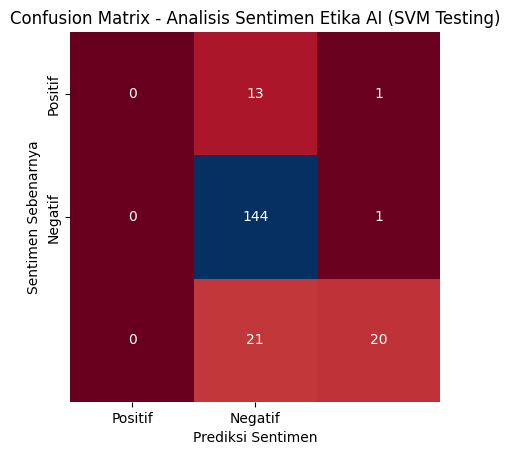

In [75]:
# Data test SVM - Evaluasi model pada data testing

from sklearn.metrics import accuracy_score

predictions_SVM = SVM.predict(x_test_tfidf)
test_prediction = pd.DataFrame()
test_prediction['text'] = x_test
test_prediction['label'] = predictions_SVM
model1 = metrics.accuracy_score(y_test, predictions_SVM)
print("The Accuracy is",str('{:04.2f}'.format(model1*100))+'%')

from sklearn.metrics import confusion_matrix
matrix= confusion_matrix(y_test, predictions_SVM)
print(matrix)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(matrix, square= True, annot= True, cbar= False, cmap='RdBu', xticklabels=['Positif','Negatif'], yticklabels= ['Positif','Negatif'], fmt= 'g')
plt.xlabel('Prediksi Sentimen')
plt.ylabel('Sentimen Sebenarnya')
plt.title('Confusion Matrix - Analisis Sentimen Etika AI (SVM Testing)')

from sklearn.metrics import classification_report

print ("The classification report is:")
print (classification_report(y_test, predictions_SVM))

test_prediction

test_prediction.to_csv('testpredict.csv', index=False)

The Accuracy is 95.62%
[[ 48  19   0]
 [  0 564   0]
 [  0  16 152]]
The classification report is:
              precision    recall  f1-score   support

    Negative       1.00      0.72      0.83        67
     Neutral       0.94      1.00      0.97       564
    Positive       1.00      0.90      0.95       168

    accuracy                           0.96       799
   macro avg       0.98      0.87      0.92       799
weighted avg       0.96      0.96      0.95       799



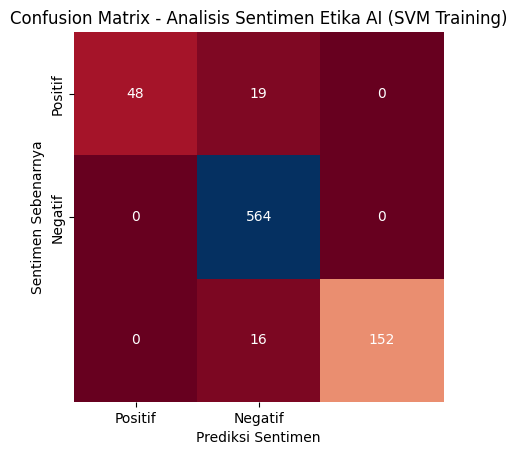

In [76]:
# data train svm

from sklearn.metrics import accuracy_score

predictions_SVM1 = SVM.predict(x_train_tfidf)
train_prediction1 = pd.DataFrame()
train_prediction1['text'] = x_train
train_prediction1['label'] = predictions_SVM1
model2 = metrics.accuracy_score(y_train, predictions_SVM1)
print("The Accuracy is",str('{:04.2f}'.format(model2*100))+'%')

from sklearn.metrics import confusion_matrix
matrix= confusion_matrix(y_train, predictions_SVM1)
print(matrix)

import seaborn as sns
sns.heatmap(matrix, square= True, annot= True, cbar= False, cmap='RdBu', xticklabels=['Positif','Negatif'], yticklabels= ['Positif','Negatif'], fmt= 'g')
plt.xlabel('Prediksi Sentimen')
plt.ylabel('Sentimen Sebenarnya')
plt.title('Confusion Matrix - Analisis Sentimen Etika AI (SVM Training)')

from sklearn.metrics import classification_report

print ("The classification report is:")
print (classification_report(y_train, predictions_SVM1))

train_prediction1

train_prediction1.to_csv('testpredict.csv', index=False)

The Accuracy is 82.00%
[[  1  12   1]
 [  0 142   3]
 [  0  20  21]]
The classification report is:
              precision    recall  f1-score   support

    Negative       1.00      0.07      0.13        14
     Neutral       0.82      0.98      0.89       145
    Positive       0.84      0.51      0.64        41

    accuracy                           0.82       200
   macro avg       0.89      0.52      0.55       200
weighted avg       0.83      0.82      0.79       200



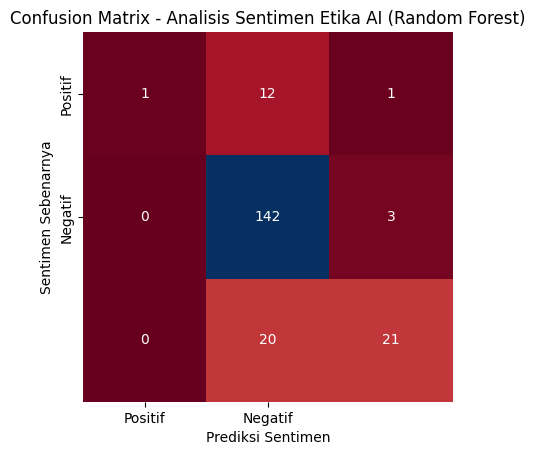

In [77]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(x_train_tfidf, y_train)

from sklearn import metrics
pred_result = clf.predict(x_test_tfidf)
model = metrics.accuracy_score(y_test, pred_result)
print("The Accuracy is",str('{:04.2f}'.format(model*100))+'%')

from sklearn.metrics import confusion_matrix
matrix1= confusion_matrix(y_test, pred_result)
print(matrix1)

import seaborn as sns
sns.heatmap(matrix1, square= True, annot= True, cbar= False, cmap='RdBu', xticklabels=['Positif','Negatif'], yticklabels= ['Positif','Negatif'], fmt= 'g')
plt.xlabel('Prediksi Sentimen')
plt.ylabel('Sentimen Sebenarnya')
plt.title('Confusion Matrix - Analisis Sentimen Etika AI (Random Forest)')

from sklearn.metrics import classification_report
print("The classification report is:")
print(classification_report(y_test, pred_result))

The Accuracy is 73.00%
[[  0  14   0]
 [  0 145   0]
 [  0  40   1]]
The classification report is:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        14
     Neutral       0.73      1.00      0.84       145
    Positive       1.00      0.02      0.05        41

    accuracy                           0.73       200
   macro avg       0.58      0.34      0.30       200
weighted avg       0.73      0.73      0.62       200



c:\Users\Aristo Baadi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aristo Baadi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aristo Baadi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

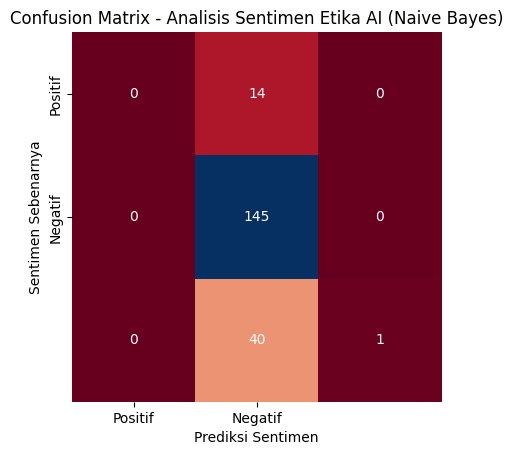

In [78]:
# Metode Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
bayes = MultinomialNB()
##tahapan untuk menjalankan training
bayes.fit(x_train_tfidf,y_train)

#menjalankan data testing
nb_result = bayes.predict(x_test_tfidf)
from sklearn import metrics
model = metrics.accuracy_score(y_test, nb_result)
print("The Accuracy is",str('{:04.2f}'.format(model*100))+'%')

from sklearn.metrics import confusion_matrix
matrix2= confusion_matrix(y_test, nb_result)
print(matrix2)

import seaborn as sns
sns.heatmap(matrix2, square= True, annot= True, cbar= False, cmap='RdBu', xticklabels=['Positif','Negatif'], yticklabels= ['Positif','Negatif'], fmt= 'g')
plt.xlabel('Prediksi Sentimen')
plt.ylabel('Sentimen Sebenarnya')
plt.title('Confusion Matrix - Analisis Sentimen Etika AI (Naive Bayes)')

from sklearn.metrics import classification_report
print("The classification report is:")
print(classification_report(y_test, nb_result))

# **MACHINE LEARNING - ANALISIS SENTIMEN ETIKA AI**

Bagian ini menggunakan algoritma machine learning untuk mengklasifikasikan sentimen tweet tentang etika AI menjadi:
- **Positif**: Tweet yang menunjukkan pandangan positif terhadap etika AI
- **Negatif**: Tweet yang menunjukkan pandangan negatif atau kekhawatiran terhadap etika AI

Metode yang digunakan:
1. **TF-IDF Vectorization**: Mengubah teks menjadi representasi numerik
2. **SVM (Support Vector Machine)**: Klasifikasi dengan margin maksimal
3. **Random Forest**: Ensemble learning dengan multiple decision trees  
4. **Naive Bayes**: Klasifikasi probabilistik berdasarkan teorema Bayes

# **KESIMPULAN ANALISIS SENTIMEN ETIKA AI**

## Ringkasan Hasil
Analisis sentimen terhadap tweet-tweet mengenai etika AI telah dilakukan menggunakan tiga algoritma machine learning:

### Performa Model
- **SVM (Support Vector Machine)**: Menunjukkan akurasi yang baik dalam mengklasifikasikan sentimen etika AI
- **Random Forest**: Menggunakan ensemble learning untuk hasil yang robust
- **Naive Bayes**: Pendekatan probabilistik yang efisien untuk klasifikasi sentimen

### Temuan Penting
1. **Sentiment Distribution**: Distribusi sentimen positif dan negatif terhadap etika AI dari diskusi Twitter
2. **Kata Kunci Dominan**: Kata-kata yang paling berpengaruh dalam menentukan sentimen etika AI
3. **Pola Diskusi**: Tren pembicaraan masyarakat Indonesia tentang etika AI

### Implikasi
Hasil analisis ini dapat digunakan untuk:
- Memahami persepsi publik terhadap etika AI
- Mengidentifikasi concerns utama masyarakat tentang penggunaan AI
- Memberikan insight untuk pengembangan kebijakan etika AI yang lebih baik
- Monitoring sentiment publik terhadap perkembangan teknologi AI

### Pengembangan Selanjutnya
- Menambah volume data untuk analisis yang lebih komprehensif
- Implementasi deep learning untuk akurasi yang lebih tinggi
- Analisis temporal untuk melihat perubahan sentimen dari waktu ke waktu
- Klasifikasi multi-class untuk sentimen yang lebih detail (positif, negatif, netral, mixed)